# Toronto Recreation

## Introduction

As the provincial capital of Ontario, Toronto is a prominent hub for its residents as well as the millions of tourists that visit per year. From nightlife to shopping to the arts, every corner of Toronto is packed with sites to visit and scenery to enjoy.

Toronto is a city full of exploration for tourists and opportunity for the entrepreneur. Due to the large amount of existing establishments, it may be difficult for an entrepreneur to decide on where to base their business. Where should they build a shopping center? A bar? What about a gym? On the other hand, a tourist only has a limited time to enjoy the city. Which districts should they visit based on their interests?


## Data

To address this issue, I will mainly use the foursquare api. First, I will determine the districts of Toronto by scraping Wikipedia. From these determined districts, I will use their longitude and latitude to search for venues within a 500m radius. Using the category of the found venues, I plan to cluster the districts of Toronto and visualize them in an interactive map.


In [46]:
! pip install --user beautifulsoup4


In [47]:
! pip install --user folium

In [48]:
#Importing Libraries

from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests
import json 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import urllib.request
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import sys
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
print('All libraries imported')

All libraries imported


In [49]:
#Scraping wikipedia

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = urllib.request.urlopen(url)
article = req.read().decode()
article2 = str(article.encode(sys.stdout.encoding, errors='replace'))
#print(article2)
with open('Postal_Codes-M.html', 'w') as fo:
    fo.write(article2)
    
article = open('Postal_Codes-M.html').read()
soup = BeautifulSoup(article, 'html.parser')
table = soup.find('table', class_='sortable')
table_rows = table.find_all('tr')
l = []
for tr in table_rows:
    if(('Not assigned' in str(tr))==False):
        td = tr.find_all('td')
        row=[tr.text for tr in td]
        l.append(row)
df = pd.DataFrame(l)
df.drop(index = 0, inplace = True)
df.columns = ['Postal Code','Borough','Neighbourhood' ]
for column in df:
    df[column] = df[column].str.replace('\\\\n','')
df.head()



,Postal Code,Borough,Neighbourhood
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government"


In [50]:
url = 'http://cocl.us/Geospatial_data'
coords = requests.get(url, allow_redirects=True)
open('c_table.csv', 'wb').write(coords.content)    
coord_table = pd.read_csv('c_table.csv')
df_coord = pd.merge(df, coord_table, on='Postal Code', how='right')
df_coord.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494


In [51]:
Toronto_df = df_coord[df_coord['Borough'].str.contains('Toronto')]
Toronto_df.set_index(['Postal Code'], inplace=True)
Toronto_df.reset_index(inplace = True)
Toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [52]:
CLIENT_ID = 'BWOB1P21JS33S2PXKD3GZFTBMCXAYROV5XDSAJR4Y2EINCUT' # your Foursquare ID
CLIENT_SECRET = '1QLIPVLNYGB40IUESTCFUO3ISCM003N1H31MFUYTJT5OKEI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

radius = 500
LIMIT = 100

Your credentails:
CLIENT_ID: BWOB1P21JS33S2PXKD3GZFTBMCXAYROV5XDSAJR4Y2EINCUT
CLIENT_SECRET:1QLIPVLNYGB40IUESTCFUO3ISCM003N1H31MFUYTJT5OKEI3


In [53]:
#categories = (4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06375d81259,4d4b7105d754a06378d81259)


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
        results = requests.get(url).json()
        counter = 0
        
        #returns venue name and category
        for v in results['response']['venues']:
            venues_list.append([(
            name, 
            lat, 
            lng,
            results['response']['venues'][counter]['name'],
            results['response']['venues'][counter]['categories'][0]['name'])])
            counter = counter + 1 


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
lat = 43.65426
lng = -79.360636
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259,4d4b7105d754a06373d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
# make the GET request
results = requests.get(url).json()

In [55]:
len(results['response']['venues'])


45

In [56]:
Toronto_venues = getNearbyVenues(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [57]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.head()

There are 234 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Sackville Playground,Park
1,"Regent Park, Harbourfront",43.65426,-79.360636,Terroni Sud Forno Produzione e Spaccio,Gourmet Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,eco|stems,Flower Shop
3,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,Historic Site
4,"Regent Park, Harbourfront",43.65426,-79.360636,Rocco's No Frills,Grocery Store


In [58]:
Toronto_venues.size

7615

In [59]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

Toronto_onehot.set_index('Neighborhood', inplace = True)
Toronto_onehot.reset_index(inplace = True)

#Toronto_onehot.head()
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,ATM,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,...,Toy / Game Store,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.023256,0.0,0.0,0.000000,0.046512,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.000000,0.0,0.0,0.046512,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.023256
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Pub,Pharmacy,Butcher,Outdoor Sculpture,Liquor Store,Grocery Store,Office,Cheese Shop,Beach,Stadium
1,"Brockton, Parkdale Village, Exhibition Place",Design Studio,General Entertainment,Salon / Barbershop,Arts & Crafts Store,Grocery Store,Department Store,Stationery Store,Beach Bar,Fruit & Vegetable Store,Sporting Goods Shop
2,"Business reply mail Processing Centre, South C...",Automotive Shop,Gym / Fitness Center,Brewery,Gas Station,Salon / Barbershop,Art Gallery,Yoga Studio,Pet Store,Boutique,Scenic Lookout
3,"CN Tower, King and Spadina, Railway Lands, Har...",Boutique,Tree,Sculpture Garden,Island,Performing Arts Venue,Harbor / Marina,Park,Convenience Store,Historic Site,Bar
4,Central Bay Street,Pharmacy,Shopping Mall,Electronics Store,Clothing Store,Skating Rink,Department Store,Bar,Grocery Store,Miscellaneous Shop,Plaza


In [62]:
Sum_of_squared_distances = []
silhouette = []
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
K = range(2,30)
for k in K:
    
    #elbow
    km = KMeans(n_clusters=k)
    inert = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(inert.inertia_)
    
    #silhouette
    preds = km.fit_predict(Toronto_grouped_clustering)
    centers = km.cluster_centers_
    silhouette=silhouette+[silhouette_score(Toronto_grouped_clustering, preds)]


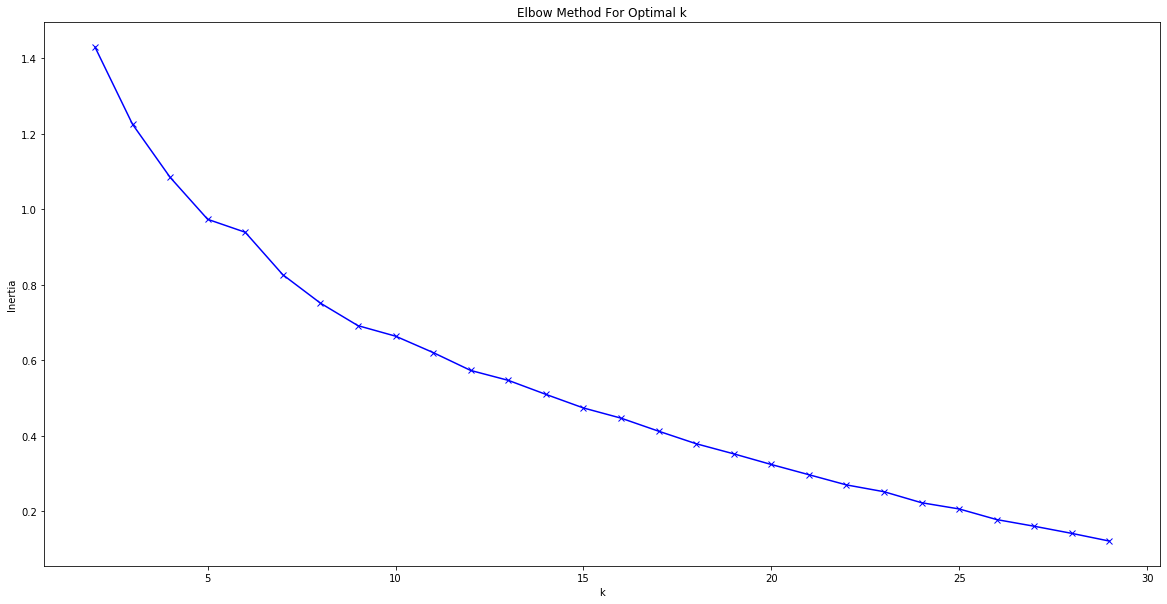

In [63]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

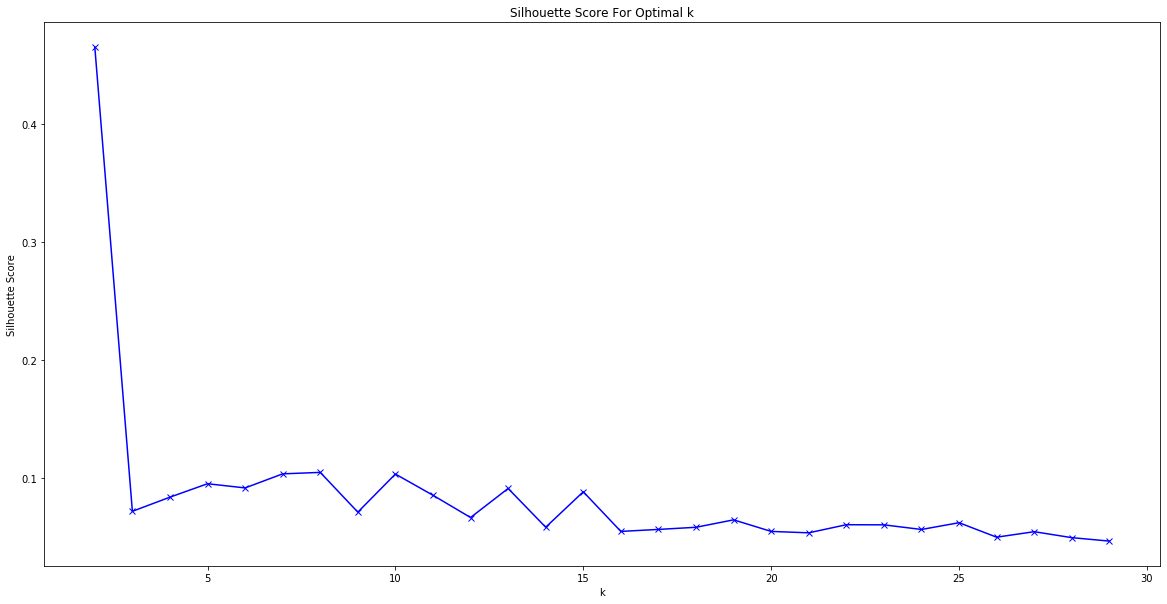

In [64]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [65]:
# set number of clusters
kclusters = 3



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 2, 1, 2, 2, 1, 1])

In [66]:
# add clustering labels
nvs = neighborhoods_venues_sorted
nvs.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(nvs.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Park,Pub,Automotive Shop,Auto Dealership,Art Gallery,Performing Arts Venue,Beer Store,Yoga Studio,Car Wash,Christmas Market
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,2,Pharmacy,Liquor Store,Skating Rink,Discount Store,Pub,Park,Convenience Store,Rock Club,Flower Shop,Costume Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Grocery Store,Supermarket,Clothing Store,Skating Rink,Furniture / Home Store,Liquor Store,Convenience Store,Gym,Pharmacy,Shopping Mall
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Pharmacy,Pub,Park,Butcher,Sports Bar,Department Store,Paper / Office Supplies Store,Convenience Store,Fish Market,Bistro
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Park,Hardware Store,Playground,Bank,Pet Store,Convenience Store,Spa,Health Food Store,Laundry Service


In [67]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,0,Spa,Playground,Strip Club,Garden,Dive Bar,Exhibit,Flower Shop,Flea Market,Fish Market,Financial or Legal Service


In [68]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",1,Park,Pub,Automotive Shop,Auto Dealership,Art Gallery,Performing Arts Venue,Beer Store,Yoga Studio,Car Wash,Christmas Market
4,The Beaches,1,Pub,Park,Hardware Store,Playground,Bank,Pet Store,Convenience Store,Spa,Health Food Store,Laundry Service
7,Christie,1,Laundry Service,Grocery Store,Design Studio,Performing Arts Venue,Art Gallery,Gym / Fitness Center,Yoga Studio,Tattoo Parlor,Flower Shop,Boutique
9,"Dufferin, Dovercourt Village",1,Furniture / Home Store,Gas Station,Athletics & Sports,Playground,Automotive Shop,Speakeasy,Dog Run,Motorcycle Shop,Clothing Store,Supermarket
10,"Harbourfront East, Union Station, Toronto Islands",1,Park,Harbor / Marina,Plaza,Grocery Store,Sports Bar,Brewery,Scenic Lookout,Restaurant,Pub,Bar


In [69]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Queen\'s Park, Ontario Provincial Government",2,Pharmacy,Liquor Store,Skating Rink,Discount Store,Pub,Park,Convenience Store,Rock Club,Flower Shop,Costume Shop
2,"Garden District, Ryerson",2,Grocery Store,Supermarket,Clothing Store,Skating Rink,Furniture / Home Store,Liquor Store,Convenience Store,Gym,Pharmacy,Shopping Mall
3,St. James Town,2,Pharmacy,Pub,Park,Butcher,Sports Bar,Department Store,Paper / Office Supplies Store,Convenience Store,Fish Market,Bistro
5,Berczy Park,2,Pub,Pharmacy,Butcher,Outdoor Sculpture,Liquor Store,Grocery Store,Office,Cheese Shop,Beach,Stadium
6,Central Bay Street,2,Pharmacy,Shopping Mall,Electronics Store,Clothing Store,Skating Rink,Department Store,Bar,Grocery Store,Miscellaneous Shop,Plaza


In [70]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 6, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [71]:
LIMIT = 100

def getNearbyVenues_Overall(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7104d754a06370d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url2 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06373d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url3 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06376d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url4 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06377d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
        url5 = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06378d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
        )
            
        # make the GET request
        results1 = requests.get(url1).json() #Arts and Entertainment
        results2 = requests.get(url2).json() #Event
        results3 = requests.get(url3).json() #Nightlife
        results4 = requests.get(url4).json() #Outdoors and Recreation
        results5 = requests.get(url5).json() #Shops and Services
        
        
        venues_list.append([(
                name, 
                lat, 
                lng,
                len(results1['response']['venues']),
                len(results2['response']['venues']),
                len(results3['response']['venues']),
                len(results4['response']['venues']),
                len(results5['response']['venues']))])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Arts and Entertainment',  
                  'Event','Nightlife', 'Outdoors and Recreation', 'Shops and Services']
    
    return(nearby_venues)

In [72]:
Toronto_venues_100 = getNearbyVenues_Overall(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [73]:
Toronto_venues_Overall = getNearbyVenues_Overall(names=Toronto_df['Neighbourhood'],
                                   latitudes=Toronto_df['Latitude'],
                                   longitudes=Toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen\'s Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport

In [74]:
Toronto_venues_100.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Arts and Entertainment,Event,Nightlife,Outdoors and Recreation,Shops and Services
0,"Regent Park, Harbourfront",43.654260,-79.360636,48,4,28,44,39
1,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,44,0,42,45,42
2,"Garden District, Ryerson",43.657162,-79.378937,42,1,48,46,50
3,St. James Town,43.651494,-79.375418,42,1,48,40,46
4,The Beaches,43.676357,-79.293031,5,0,7,19,39


In [90]:
Tvc_sorted = Toronto_venues_100.copy()
Tvc_sorted.drop(columns=['Neighborhood Latitude', 'Neighborhood Longitude'], inplace = True)
Tvc_sorted.head()

,Neighborhood,Arts and Entertainment,Event,Nightlife,Outdoors and Recreation,Shops and Services
0,"Regent Park, Harbourfront",48,4,28,44,39
1,"Queen\'s Park, Ontario Provincial Government",44,0,42,45,42
2,"Garden District, Ryerson",42,1,48,46,50
3,St. James Town,42,1,48,40,46
4,The Beaches,5,0,7,19,39


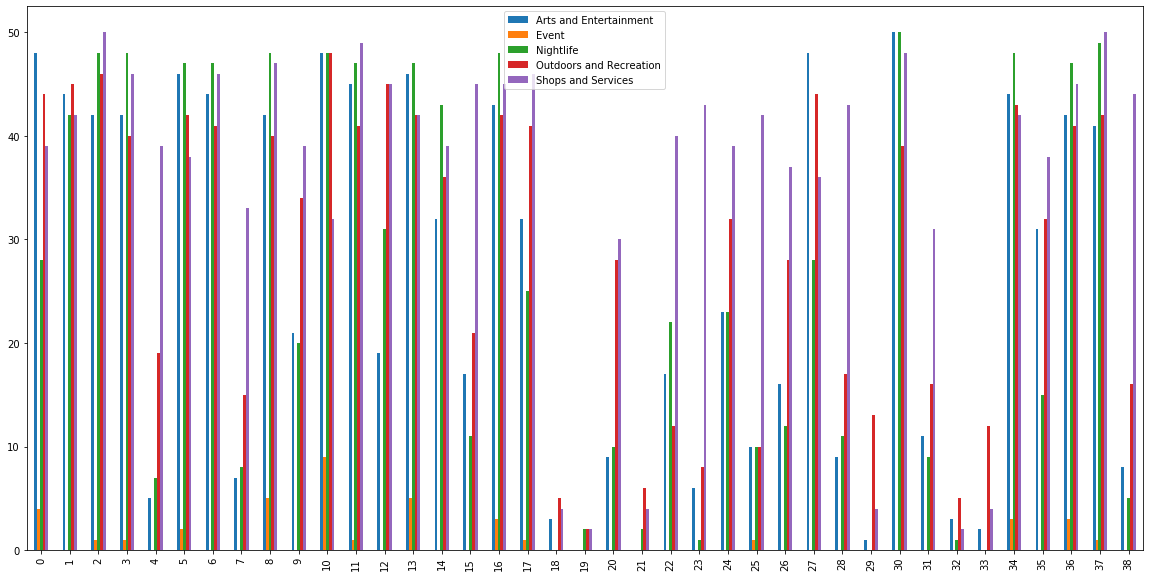

In [91]:
Tvc_sorted.plot(kind = 'bar', figsize = (20,10))

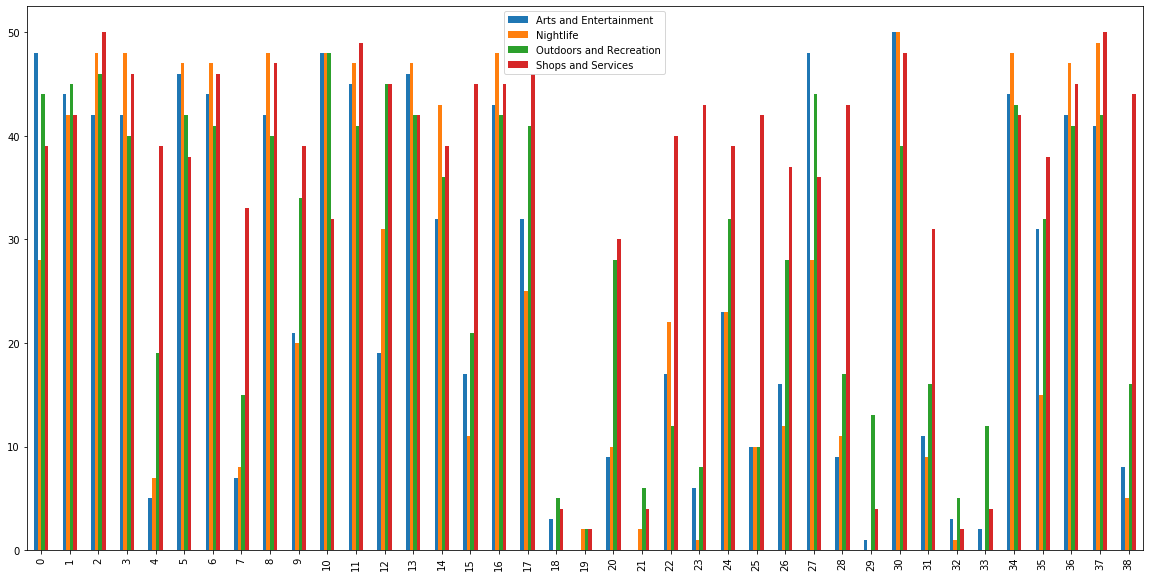

In [92]:
Tvc_sorted.drop(columns = ['Event'], inplace = True)
Tvc_sorted.plot(kind = 'bar', figsize = (20,10))

In [93]:
Tvc_sorted['Totals'] = Tvc_sorted.sum(axis = 1)

In [94]:
Tvc_sorted_Ratio = Tvc_sorted.copy()
Tvc_sorted_Ratio.head()

,Neighborhood,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services,Totals
0,"Regent Park, Harbourfront",48,28,44,39,159
1,"Queen\'s Park, Ontario Provincial Government",44,42,45,42,173
2,"Garden District, Ryerson",42,48,46,50,186
3,St. James Town,42,48,40,46,176
4,The Beaches,5,7,19,39,70


In [95]:

Tvc_sorted_Ratio['Arts and Entertainment']=Tvc_sorted_Ratio['Arts and Entertainment']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Nightlife']=Tvc_sorted_Ratio['Nightlife']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Outdoors and Recreation']=Tvc_sorted_Ratio['Outdoors and Recreation']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio['Shops and Services']=Tvc_sorted_Ratio['Shops and Services']/Tvc_sorted_Ratio['Totals']
Tvc_sorted_Ratio.drop(columns = 'Totals', inplace = True)

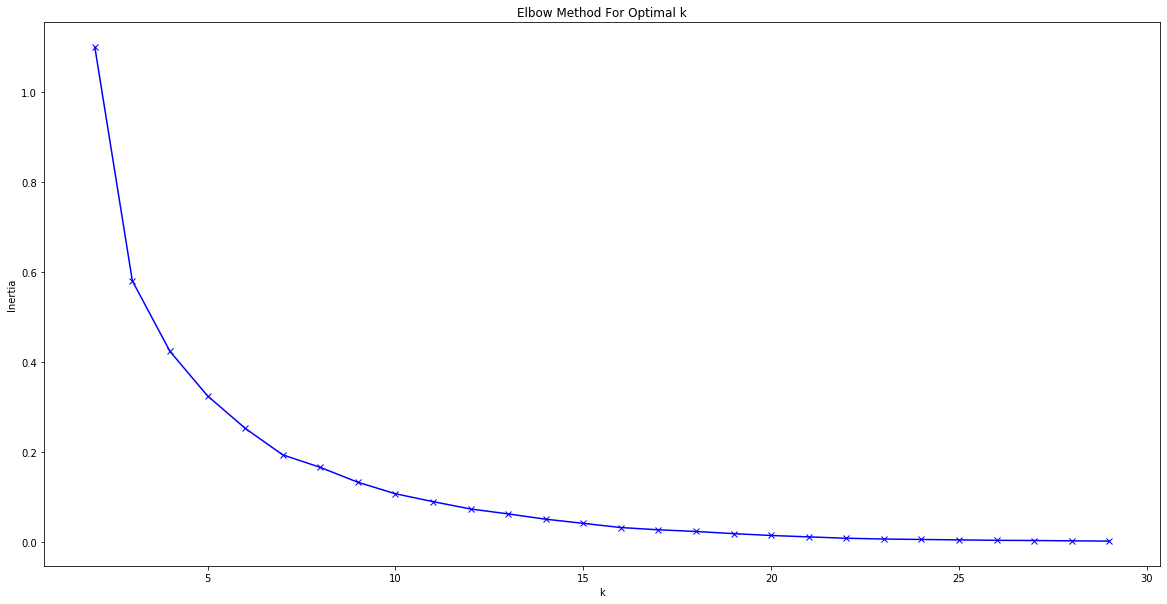

In [96]:
Sum_of_squared_distances = []
silhouette = []
Tvc_sorted_Clustering = Tvc_sorted_Ratio.drop('Neighborhood', 1)
K = range(2,30)
for k in K:
    
    #elbow
    km = KMeans(n_clusters=k)
    inert = km.fit(Tvc_sorted_Clustering)
    Sum_of_squared_distances.append(inert.inertia_)
    
    #silhouette
    preds = km.fit_predict(Tvc_sorted_Clustering)
    centers = km.cluster_centers_
    silhouette=silhouette+[silhouette_score(Tvc_sorted_Clustering, preds)]

fig= plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

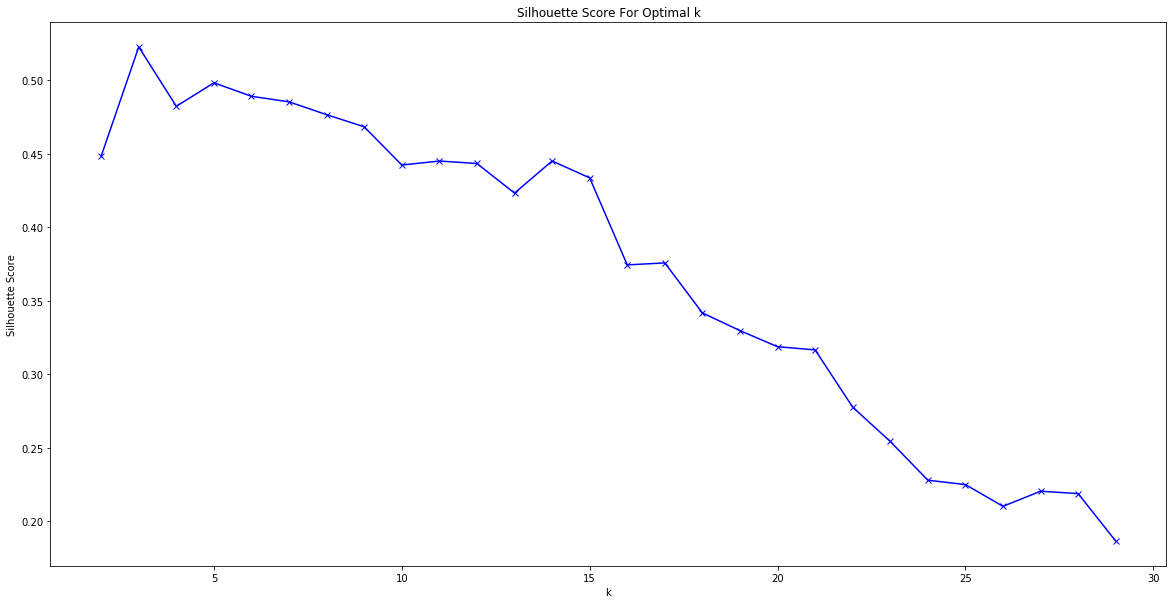

In [97]:
fig= plt.figure(figsize=(20,10))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [98]:
# set number of clusters
kclusters = 5



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tvc_sorted_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 4, 3, 4, 4, 3, 4, 1])

In [99]:
# add clustering labels
Final = Tvc_sorted_Ratio.copy()
Final.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged_final = Toronto_df.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_final = Toronto_merged_final.join(Final.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged_final.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.301887,0.176101,0.276730,0.245283
1,M7A,Downtown Toronto,"Queen\'s Park, Ontario Provincial Government",43.662301,-79.389494,4,0.254335,0.242775,0.260116,0.242775
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,0.225806,0.258065,0.247312,0.268817
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,0.238636,0.272727,0.227273,0.261364
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,0.071429,0.100000,0.271429,0.557143


In [118]:
#Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[2] + list(range(5, Toronto_merged.shape[1]))]]
c0=Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 0]

In [116]:
c1 = Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 1]


In [138]:
c2 = Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 2]
c2

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Arts and Entertainment,Nightlife,Outdoors and Recreation,Shops and Services
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2,0.055556,0.0,0.722222,0.222222
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,2,0.111111,0.0,0.666667,0.222222


In [117]:
c3=Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 3]

In [119]:
c4=Toronto_merged_final.loc[Toronto_merged_final['Cluster Labels'] == 4]

In [131]:
cluster_avg = Toronto_merged_final.groupby('Cluster Labels').mean().drop(columns = ['Latitude','Longitude'])

In [129]:
cluster_size = Toronto_merged_final.groupby('Cluster Labels').size()

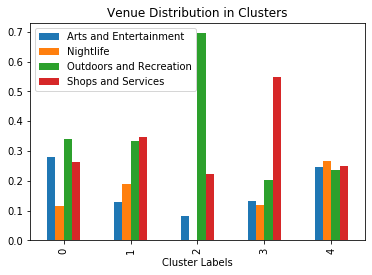

In [137]:
cluster_avg.plot(kind = 'bar', title = 'Venue Distribution in Clusters')

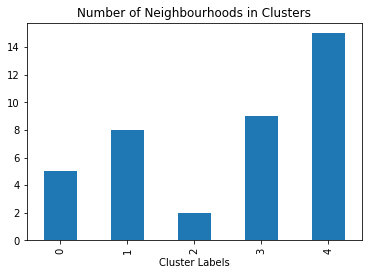

In [136]:
cluster_size.plot(kind = 'bar', title = 'Number of Neighbourhoods in Clusters')

In [112]:
long = 43.7043
lat = -79.3883
map_Toronto = folium.Map(location=[long, lat], zoom_start=11)
kclusters = 5

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_final['Latitude'], Toronto_merged_final['Longitude'], Toronto_merged_final['Neighbourhood'], Toronto_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_Toronto)
       
map_Toronto